# Motherbrain DS 🤖

> The goal is to find an interesting subset of companies (preferably quite small) that show an increasing trend in funding.
Imagine that you are an VC investor and want to find the newest trend people are investing in. Your primary interest in Series B or Series A funding and hence some early Seed investors are probably already jumping on the trend.
Try to find a group of companies that do similar things and that have received a lot of interest from early stage investors recently.



# Download files

In [0]:
from google.colab import auth
auth.authenticate_user()

!gsutil -m cp -r gs://motherbrain-external-test/interview-test-funding.json.gz .
!gsutil -m cp -r gs://motherbrain-external-test/interview-test-org.json.gz .
  
!gunzip interview-test-funding.json.gz
!gunzip interview-test-org.json.gz

Copying gs://motherbrain-external-test/interview-test-funding.json.gz...
/ [1/1 files][ 18.2 MiB/ 18.2 MiB] 100% Done                                    
Operation completed over 1 objects/18.2 MiB.                                     
Copying gs://motherbrain-external-test/interview-test-org.json.gz...
| [1/1 files][172.0 MiB/172.0 MiB] 100% Done                                    
Operation completed over 1 objects/172.0 MiB.                                    


# Import dependencies 

In [0]:
!pip install gensim nltk pyLDAvis wordcloud

In [0]:
import pandas as pd
import numpy as np
import re

import wordcloud
import sklearn
import gensim

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') 

import pyLDAvis


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data exploration and analysis

In [0]:
funding = pd.read_json('interview-test-funding.json', lines=True)
org = pd.read_json('interview-test-org.json', lines=True)

In [0]:
funding.head()

,funding_round_uuid,company_uuid,company_name,investment_type,announced_on,raised_amount_usd,investor_names,investor_count
0,2ace3f55-5a66-484c-ce06-3a326f8eaafd,6faee0d4-a0d2-3404-f9a3-441ca46fccf0,CryptoPing,initial_coin_offering,2017-07-07,2600000.0,{},NaN
1,36380646-783c-0618-d61e-d9708c4c9366,d319be0c-1b6a-a685-ef1e-ac79d04605ce,WaterO,product_crowdfunding,2016-04-01,85669.0,{},NaN
2,4b52d69d-c681-44e1-ba88-1113df10dfa5,565777f7-c91e-47f8-8027-6b3617e3d7bf,LoopX,initial_coin_offering,2018-02-12,4500000.0,{},NaN
3,4bc097d2-671f-45a3-890a-ca32980f939a,90ef7195-1681-45c2-870d-c47647240f29,Lancer Network,initial_coin_offering,2018-05-26,NaN,{},NaN
4,590a9864-9a4d-4c8f-81c1-5aa443f14af3,85c58328-3b67-4b92-ba6e-167ba1d2072f,Fullframe Design,product_crowdfunding,2019-09-20,422293.0,{},NaN


In [0]:
org.columns

Index(['uuid', 'company_name', 'homepage_url', 'country_code', 'city',
       'founded_on', 'short_description', 'description', 'funding_rounds',
       'funding_total_usd', 'employee_count', 'last_funding_on'],
      dtype='object')

In [0]:
print ("There are in total ", len(funding), "fundings and", len(org), "organizations." + "Out of these orgs, there are ",
      len(org[org.last_funding_on.notnull()]), "have gotten investments.")

There are in total  284307 fundings and 803824 organizations.Out of these orgs, there are  153494 have gotten investments.


## Which are the companies that got the most fundings over the years?

In [0]:
# Filter out only the fundings later than "2000-01-01"
fundings = funding[funding.announced_on > '2000-01-01']

companies = fundings.groupby('company_name').agg({'raised_amount_usd':'sum', 
                                                  'funding_round_uuid':'count'}).sort_values(by='raised_amount_usd', ascending=False)
companies.head()

,raised_amount_usd,funding_round_uuid
company_name,,
Verizon Communications,3.007981e+10,7
Uber,2.471245e+10,22
Ant Financial,2.200000e+10,4
Tsinghua Unigroup,2.180169e+10,1
Didi Chuxing,2.124470e+10,18


In [0]:
# Making a time series of funding rounds for each company
funding_time = fundings[['company_name', 'investment_type', 'announced_on']]
funding_time = funding_time.groupby(['company_name', 'investment_type']).min().reset_index().sort_values(['company_name', 'announced_on'])

funding_time[funding_time.company_name=='Uber']

,company_name,investment_type,announced_on
199565,Uber,seed,2009-08-08
199558,Uber,angel,2010-10-15
199566,Uber,series_a,2011-02-14
199567,Uber,series_b,2011-12-07
199568,Uber,series_c,2013-08-23
199569,Uber,series_d,2014-06-06
199570,Uber,series_e,2014-12-04
199559,Uber,convertible_note,2015-01-21
199571,Uber,series_f,2015-07-31
199563,Uber,private_equity,2015-08-19


## How does the investment landscape look like during the last years?

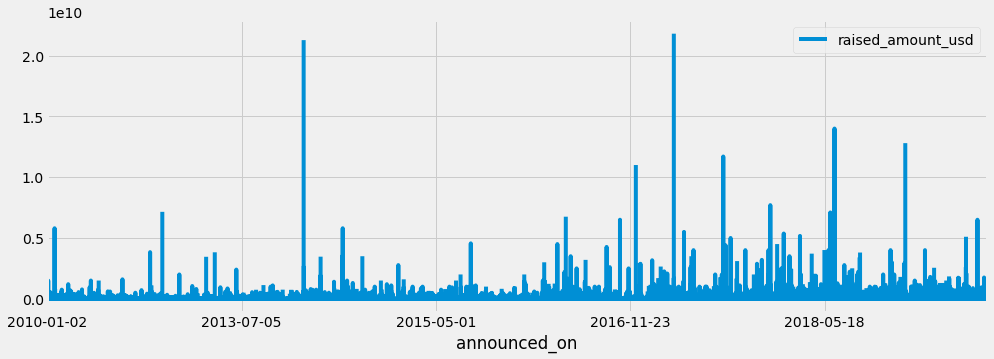

In [0]:
# Raised amount overall over the years
fundings[fundings.announced_on>'2010-01-01'].sort_values(by='announced_on').plot(x='announced_on', y='raised_amount_usd', figsize=(15,5))

We can see after 2016, investments amounts and density have both increased overall. And the same goes for early stage investments as following:

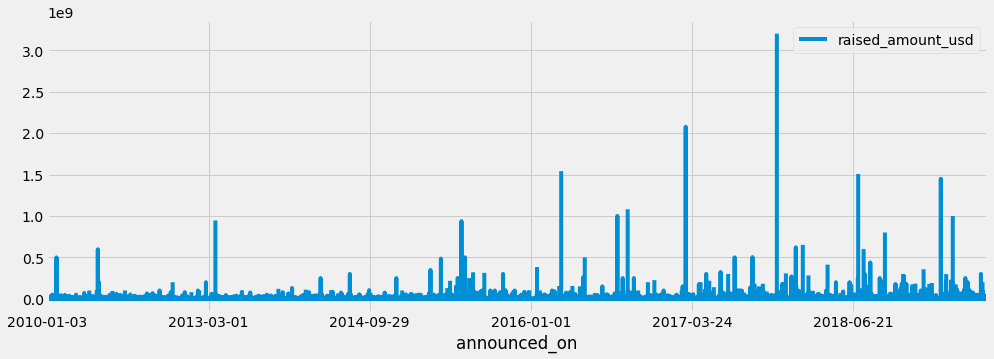

In [0]:
fundings[(fundings.announced_on>'2010-01-01') & (fundings.investment_type.isin(["angel", "seed", "series_a"]))].sort_values(by='announced_on').plot(x='announced_on', y='raised_amount_usd', figsize=(15,5))

## What's the funding flow? How does the funding stages evolve?

In [0]:
print (set(funding.investment_type))

In [0]:
funding_time['to_funding_phase'] = funding_time.groupby('company_name')['investment_type'].shift(-1)
funding_time.rename(columns = {'investment_type': 'from_investment_phase'}, inplace=True)

In [0]:
# If we only look at the main stages

crosstab = pd.crosstab(funding_time.from_investment_phase, funding_time.to_funding_phase)
crosstab.reindex(index=['pre_seed', 'seed', 'grant', 'angel', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'private_equity'], 
                 columns = ['pre_seed', 'seed', 'grant',  'angel', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'private_equity'])

to_funding_phase,pre_seed,seed,grant,angel,series_a,series_b,series_c,series_d,series_e,series_f,private_equity
from_investment_phase,,,,,,,,,,,
pre_seed,0,1457,93,44,79,4,0,3,0,0,3
seed,194,0,1194,1812,7360,326,34,3,3,1,118
grant,107,931,0,174,302,158,55,23,5,3,21
angel,145,1987,221,0,1283,81,9,1,0,0,27
series_a,12,65,265,15,0,10122,186,30,6,0,138
series_b,4,26,132,3,5,0,5357,143,20,3,112
series_c,6,12,56,3,8,5,0,2375,72,4,77
series_d,0,10,19,0,3,1,0,0,950,18,53
series_e,0,4,10,1,2,1,0,2,0,360,34


We can see from above crosstab the normal flow of funding is from preseed or angel -> seed, or from seed -> angel, and then go to series a, b, c, d...

In [0]:
early_funding = funding_time[funding_time.investment_type.isin(['pre_seed', 'seed', 'angel', 'series_a', 'series_b', 'series_c', 'series_d'])
                         & funding_time.to_funding_phase.isin(['pre_seed', 'seed', 'angel', 'series_a', 'series_b', 'series_c', 'series_d'])]
#funding

In [0]:
import networkx as nx

def plot_network(df):
    G = nx.from_pandas_edgelist(df, 'investment_type', 'to_funding_phase')
    DiG = nx.DiGraph(G)
    fig,ax=plt.subplots(figsize=(5,5))
    # Plot it
    nx.draw(DiG, with_labels=True, font_color='black', edge_color='green', arrows=False)
    plt.show()
 

plot_network(early_funding)  

In [0]:
fundings.head()

## Get the companies that got early stage investments recently

In [0]:
# Define some filters
date_filter = '2019-01-01'
#funding_type = ['pre_seed', 'seed', 'series_a', 'series_b']
funding_type = ['angel', 'pre_seed', 'seed', 'series_a']
raised_amount_thres = 100000

recent_funded = fundings[(fundings.announced_on > date_filter) 
         & (fundings.investment_type.isin(funding_type)) 
         & (fundings.raised_amount_usd > raised_amount_thres)].sort_values(
          by = 'raised_amount_usd', ascending = False)

In [0]:
len(recent_funded)

6148

In [0]:
joined_df = recent_funded.merge(org, how='inner' )

#joined_df.head()
#len(set(joined_df.company_name))

In [0]:
joined_df.groupby('investment_type').agg({'raised_amount_usd':'sum', 'funding_round_uuid':'count'})

,raised_amount_usd,funding_round_uuid
investment_type,,
angel,6.501099e+08,338
pre_seed,2.739085e+08,528
seed,6.936627e+09,3663
series_a,3.135016e+10,2356


In [0]:
# Drop the rows without description
joined_df = joined_df.dropna(subset=['description']).reset_index()
len(joined_df)

5809

# Build a LDA model to group topics on recently invested companies

In [0]:
# Comopany descriptions
corpus = [joined_df.description[i] for i in range(len(joined_df))]

In [0]:
corpus[0]

'T3 Mobile Travel Services offers car-sharing services powered by renewable energy. T3 is purely market-driven, with a mission to build what it calls a “smart mobility ecosystem” by combining the data capability of its technology partners with the manufacturing know-how of its automakers.'

## Which are the most used words in the description? 📚

In [0]:
countVectorizer = CountVectorizer(stop_words=stopwords.words('english'))
countVector = countVectorizer.fit_transform(corpus)

count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

pd.Series(count_vect_df.sum()).sort_values(ascending=False)[:20]

platform      2169
company       1885
technology    1758
data          1622
based         1368
time          1022
new           1010
business       894
service        892
products       892
world          873
services       860
founded        845
provides       820
software       800
people         767
companies      752
management     747
solutions      743
experience     741
dtype: int64

## Text cleaning 🧹

In [0]:
min_len = 3
no_below = 20
no_above = 0.3

# Filter out URLs
corpus = [re.sub(r'http\S+', '', doc, flags=re.MULTILINE) for doc in corpus]

# Tokenize
tokens = [[word.lower() for word in nltk.word_tokenize(doc) if word.isalpha() and len(word) >= min_len] for doc in corpus]

# Remove stop words
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(["platform", "technology", "product", "products", "development", "develop", "manage", "service", "services", "provides", "provide", 
                   "business", "solutions", "businesses","strategy", "company", "companies", "new", "team", "customer", "customers", "founded", "users", "people", "really", "want"])

tokens = [[word for word in doc if word not in stop_words] for doc in tokens]

# Only keep nouns
tags = [[word for word in nltk.pos_tag(doc)] for doc in tokens]
texts = [[word for word, pos in doc if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')] for doc in tags]

# Normalize
#stemmer = nltk.stem.PorterStemmer()
#corpus = [[stemmer.stem(word) for word in doc] for doc in corpus]
#lemm = nltk.stem.WordNetLemmatizer()
#corpus = [[lemm.lemmatize(word) for word in doc] for doc in corpus]



In [0]:
# Build dictionary & filter out rare and common words
dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=no_below, no_above=no_above)
print(dictionary)


Dictionary(1006 unique tokens: ['build', 'data', 'ecosystem', 'energy', 'mobility']...)


## Build a model 🧮

In [0]:
# To assign a seed for model
fixed_seed = 42
np.random.seed(fixed_seed)

corpus_bow = [dictionary.doc2bow(doc) for doc in texts]

num_topics = 15
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus_bow,
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            #chunksize=2000,
                                            #eval_every=None,
                                            passes=100,
                                            alpha=0.01*num_topics,
                                            eta=0.01*len(dictionary.keys()),
                                            per_word_topics=True
                                           )


In [0]:
# Most important words in each topic
lda_model_2.show_topics(num_topics,5)

[(0,
  '0.020*"insurance" + 0.009*"space" + 0.004*"hotel" + 0.003*"spaces" + 0.003*"claims"'),
 (1,
  '0.011*"payment" + 0.010*"travel" + 0.009*"car" + 0.009*"credit" + 0.007*"payments"'),
 (2,
  '0.033*"health" + 0.018*"care" + 0.012*"healthcare" + 0.011*"patients" + 0.006*"information"'),
 (3,
  '0.036*"data" + 0.019*"software" + 0.014*"management" + 0.012*"industry" + 0.010*"intelligence"'),
 (4,
  '0.014*"brands" + 0.012*"sales" + 0.010*"marketing" + 0.010*"brand" + 0.010*"media"'),
 (5,
  '0.009*"games" + 0.009*"music" + 0.009*"app" + 0.009*"game" + 0.007*"video"'),
 (6,
  '0.010*"energy" + 0.003*"box" + 0.002*"gas" + 0.002*"oil" + 0.002*"storage"'),
 (7,
  '0.011*"research" + 0.004*"crop" + 0.003*"university" + 0.002*"water" + 0.002*"production"'),
 (8,
  '0.006*"coffee" + 0.004*"candidates" + 0.002*"recruitment" + 0.002*"job" + 0.002*"employers"'),
 (9,
  '0.011*"world" + 0.011*"way" + 0.011*"experience" + 0.010*"time" + 0.009*"food"'),
 (10,
  '0.019*"home" + 0.008*"event" + 0.

## Visualization of topics 📊

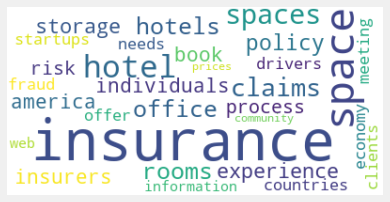

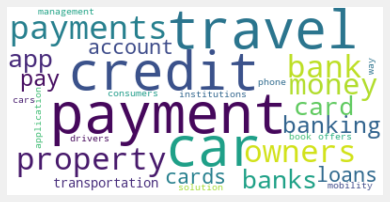

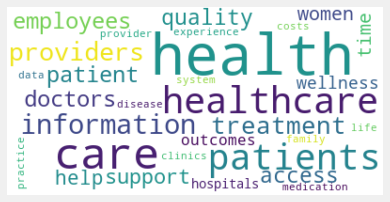

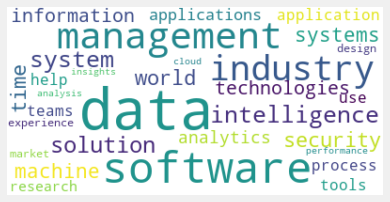

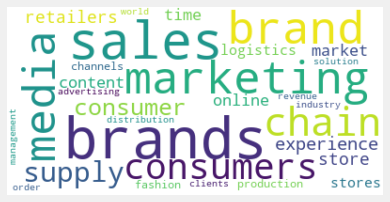

In [0]:
# Plot wordcloud
show_topics = 5
show_words = 30

def plot_word_cloud(freqs):
  wc = wordcloud.WordCloud(max_font_size=60, max_words=100, background_color="white")
  wc = wc.generate_from_frequencies(freqs)
  plt.figure()
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  
for topic in range(show_topics):
  plot_word_cloud(dict(lda_model_2.show_topic(topic, show_words)))

In [0]:
from pyLDAvis import gensim as LDAvis

pyLDAvis.enable_notebook()
LDAvis.prepare(lda_model_2, corpus_bow, dictionary, mds='tsne')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      215.409897 -395.523834  1       1        33.053200
9      23.436188   320.478424  2       1        18.295654
4      119.399879  67.449142   3       1        10.914232
1      192.886658 -136.369858  4       1        7.343872 
2     -369.245300  72.458183   5       1        6.786292 
5     -189.240585 -116.221588  6       1        5.642746 
11    -239.208344 -370.430084  7       1        4.130529 
10    -94.049088   78.284706   8       1        2.902630 
0      276.842896  266.838593  9       1        2.473204 
7     -428.874664 -187.695312  10      1        1.758166 
14     422.175140 -233.028488  11      1        1.613506 
12     391.416565  33.388153   12      1        1.524902 
6     -17.630346  -485.530334  13      1        1.443977 
8     -233.859619  290.835205  14      1        1.199838 
13    -3.154106   -223.728653  15      1        0.917246 , topic_info=    Category         Freq       Term        Total  loglift  logprob
1    Default  1018.000000  data       1018.000000  30.0000  30.0000
8    Default  220.000000   health     220.000000   29.0000  29.0000
88   Default  213.000000   research   213.000000   28.0000  28.0000
446  Default  114.000000   insurance  114.000000   27.0000  27.0000
28   Default  128.000000   home       128.000000   26.0000  26.0000
..       ...         ...    ...              ...       ...      ...
350  Topic15  0.772647     areas      79.126869    0.0626  -6.8541 
541  Topic15  0.772573     asset      95.631340   -0.1270  -6.8542 
221  Topic15  0.772870     assets     102.170670  -0.1927  -6.8539 
55   Topic15  0.773117     provider   146.434464  -0.5524  -6.8535 
441  Topic15  0.767092     security   248.580109  -1.0894  -6.8614 

[729 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
952   1      0.171253  accelerator
952   2      0.247365  accelerator
952   3      0.114169  accelerator
952   4      0.076112  accelerator
952   5      0.076112  accelerator
...  ..           ...          ...
436   11     0.056181  york       
436   12     0.014045  york       
436   13     0.014045  york       
436   14     0.014045  york       
436   15     0.014045  york       

[7515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 5, 2, 3, 6, 12, 11, 1, 8, 15, 13, 7, 9, 14])

In [0]:
# To put topic and desctiption together for inspection

def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)



In [0]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_2, corpus=corpus_bow, texts=corpus)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic = df_dominant_topic.set_index('Document_No')


In [0]:
pd.set_option('display.max_colwidth', 0)
df_dominant_topic[:5]

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
Document_No,,,,
0,3.0,0.5001,"data, software, management, industry, intelligence, system, solution, world, security, time","T3 Mobile Travel Services offers car-sharing services powered by renewable energy. T3 is purely market-driven, with a mission to build what it calls a “smart mobility ecosystem” by combining the data capability of its technology partners with the manufacturing know-how of its automakers."
1,2.0,0.5995,"health, care, healthcare, patients, information, providers, treatment, patient, employees, doctors","JD Health is an e-commerce platform for pharmaceutical products such as vitamins & supplements, medical supplies, contact lenses, adult products, traditional medicine, and more. It is the healthcare subsidiary of JD.com."
2,4.0,0.9094,"brands, sales, marketing, brand, media, chain, consumers, supply, consumer, experience","JUSDA, a service platform of supply chain management for Foxconn Technology Group and a pilot in integrating C2C (Component to Consumer) supply chain services around the world, is committed to driving professionalism and growth of supply chain management by advanced technology and R&D. The company applies an innovative business model that covers trading flow, goods flow, information flow, capital flow, technology flow and process flow."
3,0.0,0.4136,"insurance, space, hotel, spaces, claims, hotels, office, rooms, policy, storage","Chengjia Apartment is a rental start-up that provides different product choices for apartments, hotels, and homestays. Chengjia Apartment extends the business scope to weekly rent, monthly rent, and long-term rent. The company creates a high-quality living environment with ingenuity, take care of every guest with hotel-style service, and creates a warm, comfortable, and temperature-friendly home. Chengjia Apartment is jointly established by China Living Hotel Group and IDG Capital. It has laid out nearly 100 properties in first-tier cities nationwide, with more than 10,000 houses and services. It was founded on 2015 and is headquartered in Shanghai, China."
4,3.0,0.5066,"data, software, management, industry, intelligence, system, solution, world, security, time","ENOVATE automobile is an high-end new energy vehicle manufacturer aiming for using intelligent science and innovative technology to change the way of future traveling ENOVATE is committed to becoming a user-defined company. It will create an evolutionary personal intelligent mobile terminal integrating with three elements of 'global design, top quality and intelligent interconnection,'​ which will bring unlimited possibilities for future travelling."


In [0]:
# Joining topics information to company and funding info

df = df_dominant_topic.join(joined_df)

# Create an announced month column
df['announced_on_m'] = df.announced_on.apply(lambda x: x[:7])
df.columns

Index(['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'index',
       'funding_round_uuid', 'company_uuid', 'company_name', 'investment_type',
       'announced_on', 'raised_amount_usd', 'investor_names', 'investor_count',
       'uuid', 'homepage_url', 'country_code', 'city', 'founded_on',
       'short_description', 'description', 'funding_rounds',
       'funding_total_usd', 'employee_count', 'last_funding_on',
       'announced_on_m'],
      dtype='object')

## Create a summary of the different categories of companies!

In [0]:
summary = df.groupby(['Dominant_Topic']).agg({'Keywords': 'first',
                                              'raised_amount_usd': 'sum', 
                                              'funding_round_uuid': 'count', # number of fundings
                                              'company_name':lambda x: x.nunique() # unique number of companies
                                              })

summary['avg_raised_amount_per_org'] = summary.raised_amount_usd / summary.company_name
summary

,Keywords,raised_amount_usd,funding_round_uuid,company_name,avg_raised_amount_per_org
Dominant_Topic,,,,,
0.0,"insurance, space, hotel, spaces, claims, hotels, office, rooms, policy, storage",9.177290e+08,129,116,7.911457e+06
1.0,"payment, travel, car, credit, payments, property, bank, owners, money, banks",2.633867e+09,421,394,6.684941e+06
2.0,"health, care, healthcare, patients, information, providers, treatment, patient, employees, doctors",2.887422e+09,357,342,8.442753e+06
3.0,"data, software, management, industry, intelligence, system, solution, world, security, time",1.295616e+10,1953,1816,7.134451e+06
4.0,"brands, sales, marketing, brand, media, chain, consumers, supply, consumer, experience",3.159970e+09,644,607,5.205881e+06
5.0,"games, music, app, game, video, content, share, world, friends, studio",1.496056e+09,371,350,4.274445e+06
6.0,"energy, box, gas, oil, storage, lines, costs, collection, projects, speed",4.274770e+08,54,52,8.220711e+06
7.0,"research, crop, university, water, production, agriculture, science, scientists, plant, order",3.398853e+08,66,66,5.149778e+06
8.0,"coffee, candidates, recruitment, job, employers, shift, jobs, hire, rewards, assessment",7.234228e+07,38,34,2.127714e+06


## What are the funding trends for each topic?

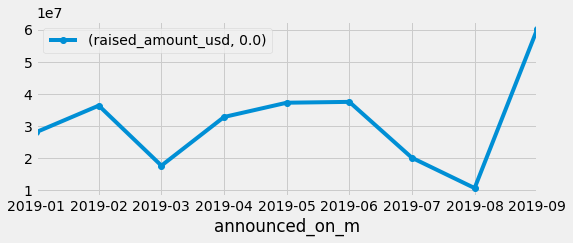

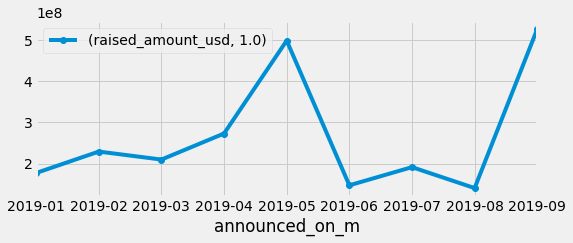

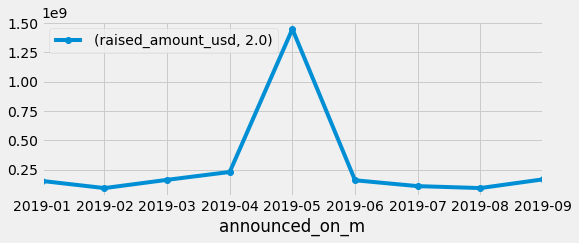

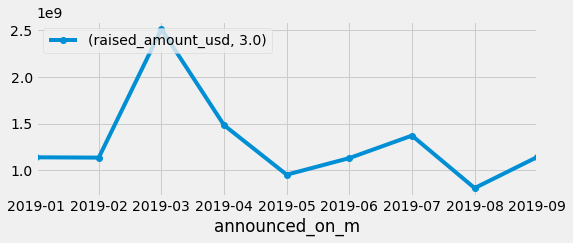

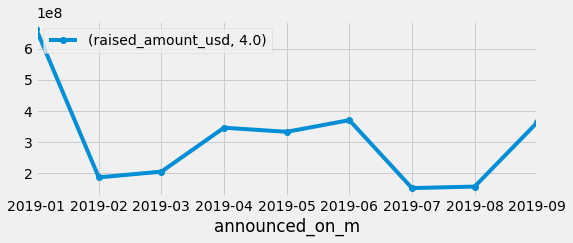

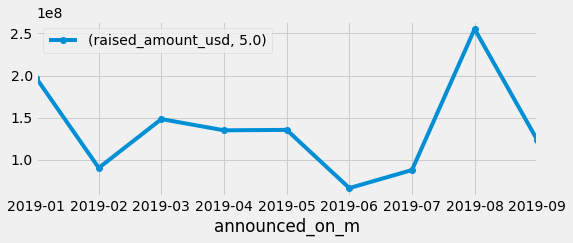

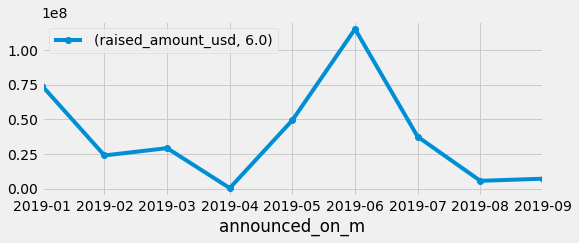

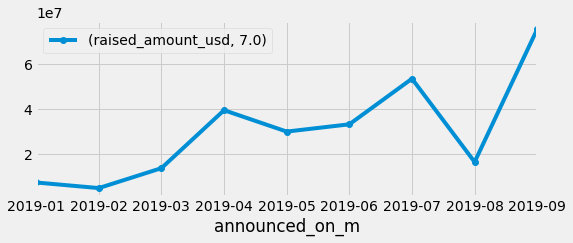

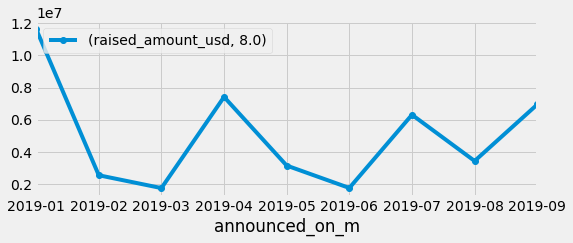

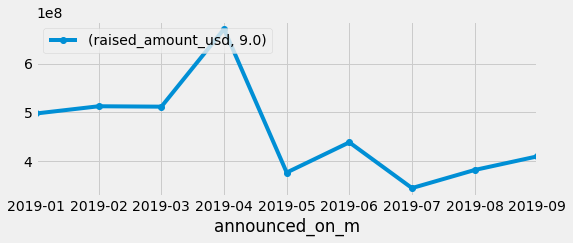

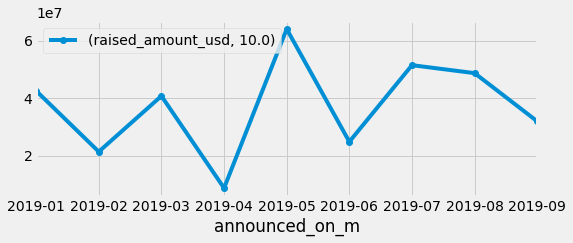

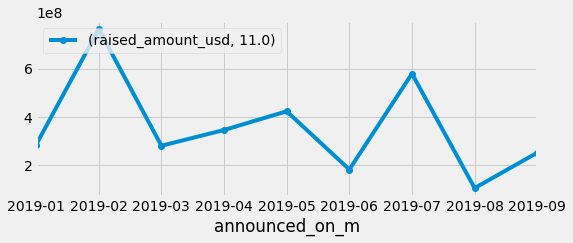

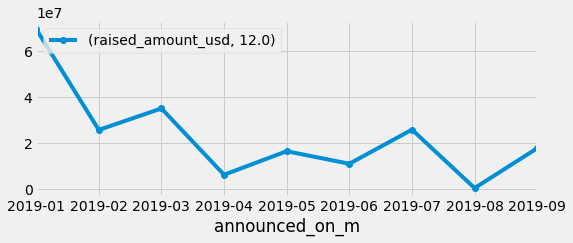

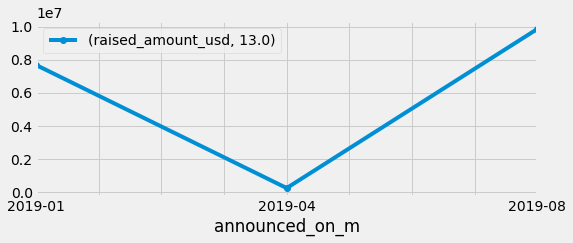

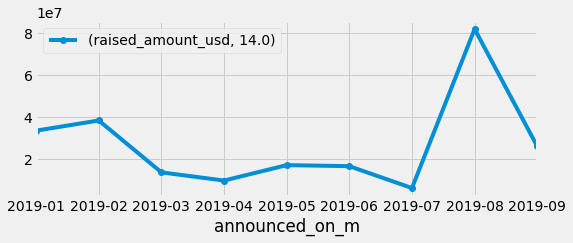

In [0]:
# Filter out outliers 
#high = np.percentile(df.raised_amount_usd, 95)
#low = np.percentile(df.raised_amount_usd, 5)

#df = df[(df.raised_amount_usd>low) & (df.raised_amount_usd<high)]
num_topics = 15
for topic in range(num_topics):
    pd.pivot_table(df[(df.Dominant_Topic == topic) & (df.Topic_Perc_Contrib > 0.5) & (df.announced_on_m != '2019-10')], 
                    values = ['raised_amount_usd'], 
                    index = 'announced_on_m', 
                    columns = 'Dominant_Topic', 
                    aggfunc = np.sum).plot.line(figsize= (8, 3), style = 'o-'
                   )
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
  


# An example of interesting subset of companies!

Looks like topic #7 has an distinct increasing trend in investment amount. Let's look into it!
Seems many are dealing with life science, bio-tech etc.

In [0]:
df[(df.Dominant_Topic == 7) & (df.Topic_Perc_Contrib > 0.85)][['company_name', 'short_description', 'homepage_url', 'investment_type', 'announced_on']]

,company_name,short_description,homepage_url,investment_type,announced_on
Document_No,,,,,
2949,1Balance,1Balance is a Herbal Supplements That Are Just Right For You.,https://www.1balance.com,seed,2019-09-26
3170,PhagoMed,PhagoMed develops phage-based pharmaceuticals to treat chronic bacterial infections.,http://www.phagomed.com/,seed,2019-06-27
3265,LipoCoat,LipoCoat is a spin-off company from the University of Twente that develops bio-inspired coatings for healthcare.,https://www.lipocoat.com,series_a,2019-04-25
3934,Farmcrowdy,Farmcrowdy is a digital agriculture platform focused on connecting farm sponsors with real farmers.,https://www.farmcrowdy.com/,seed,2019-03-21
4580,Antibodies.com,"Antibodies.com is a leading supplier of protein research tools. Discover more from our range of distinct antibodies, proteins, and assays.",https://www.antibodies.com,pre_seed,2019-07-02
4674,BioSeek JSC,Online search engine for Life Science,http://www.bioseek.eu,seed,2019-08-21
4756,geoSilica,geoSilica is the leading Icelandic company in the research and development of extracting minerals from geothermal water.,https://geosilica.is,series_a,2019-01-26


# This is just a start.

> Due to limited time, this is a demonstration of a case study in how we can explore the data and how to tackle this problem. There will be a lot more further work to do in terms of approaches of modelling and visualization since the clusters now are far from perfect. We can also look back into the history and find patterns in the successful companies to infer on the companies we are looking into. All in all this is a really interesting and challenging task!







